#  trained_model 사용 방법

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1MHdcqIyIV0muEhg2gqabkLe2mw25nuKN#scrollTo=IHfWz4FoO25F)

1. pix2pix/trained_model의 파일 중 사용할 모델을(generator v1(100e)와 v2(125e) 내컴퓨터에 다운로드
2. 본인의 구글 드라이브에 'pix2pix'라는 이름의 폴더를 만든다.
3. 'pix2pix' 폴더 내부에 각각 'trained_model'이라는 이름의 폴더를 만들어 1에서 다운받은 파일(모델)을 업로드한다.
4. +이미지 파일이 여러장 있는 폴더로 결과물을 한번에 내보고 싶다면 해당 폴더도 구글 드라이브에 사전에 업로드한다.

## 1.구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.라이브러리 불러오기, 모델 정의하기

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

transforms_ = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [3]:
# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x


# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]
        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up5 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up6 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up7 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


# U-Net 판별자(Discriminator) 아키텍처
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_channels, out_channels, normalization=True):
            # 너비와 높이가 2배씩 감소
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # 두 개의 이미지(실제/변환된 이미지, 조건 이미지)를 입력 받으므로 입력 채널의 크기는 2배
            *discriminator_block(in_channels * 2, 64, normalization=False), # 출력: [64 X 128 X 128]
            *discriminator_block(64, 128), # 출력: [128 X 64 X 64]
            *discriminator_block(128, 256), # 출력: [256 X 32 X 32]
            *discriminator_block(256, 512), # 출력: [512 X 16 X 16]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False) # 출력: [1 X 16 X 16]
        )

    # img_A: 실제/변환된 이미지, img_B: 조건(condition)
    def forward(self, img_A, img_B):
        # 이미지 두 개를 채널 레벨에서 연결하여(concatenate) 입력 데이터 생성
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)




def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [4]:
from __future__ import print_function
import argparse

from torch.autograd import Variable

import PIL.Image
import PIL.ImageTk
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = PIL.Image.open(filepath).convert('RGB')
    img = img.resize((256, 256))
    return img


def save_img(image_tensor, filename):
    image_numpy = image_tensor.float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    image_numpy = image_numpy.astype(np.uint8)
    image_pil = Image.fromarray(image_numpy)
    image_pil.save(filename)
    print("Image saved as {}".format(filename))


parser = argparse.ArgumentParser()
parser.add_argument('--dataset', required=False, default='illustration', help='illustration')
parser.add_argument('--model', required=False, type=str, default='Pix2Pix_Generator_V1(1).pt', help='model file to use')
parser.add_argument('--cuda', action='store_true', default=True, help='use cuda')
params = parser.parse_args([])
print(params)

Namespace(cuda=True, dataset='illustration', model='Pix2Pix_Generator_V1(1).pt')


## 3.모델 불러오기

1차 모델을 generator1으로, 2차 모델을 generator2로 불러옴

In [5]:
%cd /content/drive/MyDrive/pix2pix/trained_model

generator1 = GeneratorUNet()
generator1.cuda()
generator2 = GeneratorUNet()
generator2.cuda()

generator1.load_state_dict(torch.load("Pix2Pix_Generator_V1(100e).pt")) 
generator2.load_state_dict(torch.load("Pix2Pix_Generator_V2(125e).pt"))  

generator1.eval();
generator2.eval();

/content/drive/MyDrive/pix2pix/trained_model


## 4.단일 이미지로 test

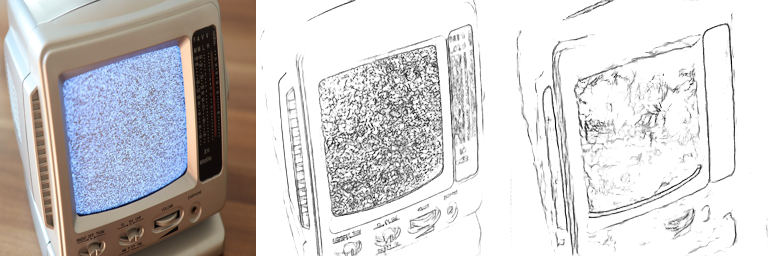

In [6]:
#@markdown #**이미지 파일 하나만 넣을 때**
#@markdown ---
target_imagefile = "/content/drive/MyDrive/tv-ge3d894862_640.jpg"#@param {type:"string"} 

imgs = load_img(target_imagefile) #인풋 이미지 경로 넣기
imgs = transforms_(imgs)

input = Variable(imgs).view(1,-1,256,256)
input_img = input.data[0]
save_image(input_img, "input.png", nrow=1, normalize=True)
input_img = cv2.imread("input.png")

if params.cuda:
    generator1 = generator1.cuda()
    generator2 = generator2.cuda()
    input = input.cuda()

# 1차 학습모델인 generator1 결과
out1 = generator1(input)
out1 = out1.cpu()
out_img1 = out1.data[0]
save_image(out_img1, "result1.png", nrow=1, normalize=True)
out_img1 = cv2.imread("result1.png")

# 2차 학습모델인 generator2 결과
out2 = generator2(input)
out2 = out2.cpu()
out_img2 = out2.data[0]
save_image(out_img2, "result2.png", nrow=1, normalize=True)
out_img2 = cv2.imread("result2.png")


add_img = np.hstack((input_img, out_img1, out_img2)) #왼쪽부터 순서대로 input, 1차 모델 결과, 2차 모델 결과
cv2_imshow(add_img)


## 5.파일이 여러장 들어있는 폴더로 test

In [ ]:
# 폴더를 압축파일로 구글드라이브에 올려놓은 경우
%cd /

!unzip '/content/drive/MyDrive/test_crawl_images.zip' -d '/'

In [11]:
target_imagefolder = "/content/crawl_images/illustration/" #반드시 슬래시(/)를 뒤에 추가해줘야 함
image_dir = target_imagefolder.format(params.dataset)  #일러스트레이션 이미지 모아놓은 폴더 경로 넣기
image_filenames =  [x for x in os.listdir(image_dir) if is_image_file(x)]

for image_name in image_filenames:
    imgs = load_img(image_dir + image_name)
    imgs = transforms_(imgs)

    input = Variable(imgs).view(1,-1,256,256)
    input_img = input.data[0]
    save_image(input_img, "input.png", nrow=1, normalize=True)
    input_img = cv2.imread("input.png")

    if params.cuda:
        generator1 = generator1.cuda()
        generator2 = generator2.cuda()
        input = input.cuda()

    #1차 학습모델인 generator1 결과
    out1 = generator1(input)
    out1 = out1.cpu()
    out_img1 = out1.data[0]
    save_image(out_img1, "result1.png", nrow=1, normalize=True)
    out_img1 = cv2.imread("result1.png")

    #2차 학습모델인 generator2 결과
    out2 = generator2(input)
    out2 = out2.cpu()
    out_img2 = out2.data[0]
    save_image(out_img2, "result2.png", nrow=1, normalize=True)
    out_img2 = cv2.imread("result2.png")

    add_img = np.hstack((input_img, out_img1, out_img2))

    cv2.imwrite('/content/drive/MyDrive/pix2pix/result_test/{}'.format(image_name), add_img) #생성한 결과 저장할 경로